In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

import matplotlib.pyplot as plt
import string
import pickle

from brian2 import *


In [3]:
code_dir = '../code'
sys.path.append(code_dir)

import config
from utils import get_label
from viz import get_gating_variable, plot_conditional_posterior, psth, plot_variable, plot_phase_shift, plot_posterior_check

In [4]:
# text
plt.rcParams['text.usetex'] = True
plt.rcParams['pdf.fonttype'] = 42

# plotting
plt.rcParams['lines.linewidth'] = 0.75

In [5]:
def plot_final_posterior(sbi_id, posterior_path=None, posterior=None, shifts=[0.01, 0.0, -0.01], labels=['advance', 'instantaneous', 'delay'], n_samples=1000,
                         limits=None, v_range=[-100, 20], thetas=None, sign_flip=True, parameters=None, yticks={},
                         figsize=(6.3, 2), fontsize=None, label_fontsize=None, label_case='lower', plot_std=False, add_gridspec_kw={}, posterior_gridspec_kw={},
                         gating_gridspec_kw={}, plot_kw={}, plot_kw_original={}, fill_between_kw={}, get_im_kw={},
                         gridspec=None, median=False, legend='right', colors=None, legend_x_offset=0, legend_y_offset=0, chars=None
                        ):
    import torch
    from sbi.analysis import eval_conditional_density
    experiment_params = config.experiment['sbi'][sbi_id].copy()
    model_type = experiment_params['model_type']
    model_name = experiment_params['model_name']
    model_params = config.model_dynamics[model_type][model_name]['parameters'].copy()
    eqs = config.model_dynamics[model_type][model_name]['eqs']

    log10 = experiment_params.pop('log10', False)
    
    add_gridspec_kw=add_gridspec_kw.copy()
    gating_gridspec_kw = gating_gridspec_kw.copy()
    
    plot_kw = plot_kw.copy()
    plot_kw.setdefault('alpha', 1)
    
    ls_original = ':'
    plot_kw_original = plot_kw_original.copy()
    plot_kw_original.setdefault('alpha', 1)
    plot_kw_original.setdefault('ls', ':')

    fill_between_kw = fill_between_kw.copy()
    fill_between_kw.setdefault('alpha', 0.2)
    
    get_im_kw = get_im_kw.copy()
    get_im_kw.setdefault('resolution', 100)
    get_im_kw.setdefault('n_samples', 1000)

    if colors is None:
        colors = [mpl.colormaps['tab10'](i) for i in range(len(shifts))]

    if parameters is None:
        parameters = []
        if 'augmented_model_params' in experiment_params:
            parameters += experiment_params['augmented_model_params']
        if 'augmented_eqs' in experiment_params:
            parameters += experiment_params['augmented_eqs']
        if 'augmented_simulation_params' in experiment_params:
            parameters += list(experiment_params['augmented_simulation_params'].keys())

    if thetas is not None:
        assert len(thetas) == len(shifts)
        assert len(thetas[0][0]) == len(parameters)
        n_samples = len(thetas[0])

    n_theta = len(parameters)

    if posterior is None:
        if posterior_path is None:
            posterior_path = os.path.join(experiment_params['save_dir'], 'sbi', sbi_id, 'posterior.p')
        if not os.path.isfile(posterior_path):
            raise FileNotFoundError
        with open(posterior_path, 'rb') as tmp:
            posterior = pickle.load(tmp)

    def get_im(row, col, posterior, limits, x_o=0*torch.ones(1), n_samples=1000, resolution=50):
        eps_margins = (limits[row, 1] - limits[row, 0]) / 1e5
        
        posterior.set_default_x(x_o)

        tmp_condition = posterior.sample(
            (n_samples,), show_progress_bars=False)
        log_prob = posterior.log_prob(tmp_condition)
        condition = tmp_condition[log_prob.argmax()]

        return eval_conditional_density(
            posterior,
            condition,
            limits,
            row,
            col,
            resolution=resolution,
            eps_margins1=eps_margins,
            eps_margins2=eps_margins,
        )
    
    v = np.arange(v_range[0], v_range[1], 0.1)
    rates = {
        '_'.join([var, x]): get_gating_variable(v=v, variable='_'.join([var, x]), model_name=model_name)
        for x in ['m', 'h']
        for var in ['alpha', 'beta']
    }
    
    gatings = {x: {} for x in ['original'] + shifts}
    for x in ['m', 'h']:
        gatings['original'][x + '_inf'] = rates['alpha_' + x] / (rates['alpha_' + x] + rates['beta_' + x])
        gatings['original']['tau_' + x] = 1e3 / (rates['alpha_' + x] + rates['beta_' + x])
        gatings['original']['g_l'] = 1
        for shift in shifts:
            if thetas is None:
                posterior.set_default_x(shift)
                thts = posterior.sample((n_samples,), show_progress_bars=False).numpy()
            else:
                thts = thetas[0]

            if log10:
                thts = 10**thts

            factors = {}
            for p in parameters:
                factors[p] =  np.repeat(thts[:, parameters.index(p)].reshape(-1, 1), len(v), axis=1)
            for x in ['m', 'h']:
                gatings[shift][x + '_inf'] = factors.get('alpha_' + x, 1) * rates['alpha_' + x] / \
                    (factors.get('alpha_' + x, 1) * rates['alpha_' + x] + \
                     factors.get('beta_' + x, 1) * rates['beta_' + x])
                gatings[shift]['tau_' + x] = 1e3 / \
                    (factors.get('alpha_' + x, 1) * rates['alpha_' + x] + \
                     factors.get('beta_' + x, 1) * rates['beta_' + x])

            gatings[shift]['g_l'] = factors.get('g_l', 1)
    
    fig = plt.figure(figsize=figsize)
    
    if gridspec is None:
        add_gridspec_kw.setdefault('width_ratios', [4,3,3])
        add_gridspec_kw.setdefault('wspace', 0.5)
        add_gridspec_kw.setdefault('left', 0.025)
        add_gridspec_kw.setdefault('top', 0.95)
        add_gridspec_kw.setdefault('bottom', 0.175)
        gating_gridspec_kw.setdefault('hspace', 0.2)
        if legend == 'right':
            add_gridspec_kw.setdefault('right', 0.8)
        elif legend == 'left':
            add_gridspec_kw.setdefault('right', 0.95)
        gs0 = fig.add_gridspec(1, 3, figure=fig, **add_gridspec_kw)
        gsp = mpl.gridspec.GridSpecFromSubplotSpec(n_theta, n_theta, subplot_spec=gs0[0], **posterior_gridspec_kw)
        gsm = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], **gating_gridspec_kw)
        gsh = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2], **gating_gridspec_kw)
    elif gridspec == 'top':
        # add_gridspec_kw.setdefault('width_ratios', [4,3,3])
        add_gridspec_kw.setdefault('wspace', 0.4)
        add_gridspec_kw.setdefault('left', 0.025)
        add_gridspec_kw.setdefault('top', 0.95)
        add_gridspec_kw.setdefault('bottom', 0.175)
        add_gridspec_kw.setdefault('right', 0.8)
        add_gridspec_kw.setdefault('height_ratios', [3, 2])
        gating_gridspec_kw.setdefault('hspace', 0.2)
        gs0 = fig.add_gridspec(2, 2, figure=fig, **add_gridspec_kw)
        gsp = mpl.gridspec.GridSpecFromSubplotSpec(n_theta, n_theta, subplot_spec=gs0[0, :], **posterior_gridspec_kw)
        gsm = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1, 0], **gating_gridspec_kw)
        gsh = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1, 1], **gating_gridspec_kw)

    xticks = [-100, -80, -60, -40, -20, 0, 20]
    xticklabels = ['', r'$-80$', '', r'$-40$', '',r'$0$', '']

    axs = []
    lines = []
    for i_g, gating in enumerate(['m', 'h']):
        for i_v, var in enumerate(['tau_{}', '{}_inf']):
            var = var.format(gating)
            ax = fig.add_subplot([gsm, gsh][i_g][i_v])
            for i_s, shift in enumerate(shifts):
                if median:
                    from scipy.stats import mstats
                    quantiles = mstats.mquantiles(gatings[shift][var], axis=0)
                    y_low, y, y_high = quantiles
                else:
                    y = gatings[shift][var].mean(0)
                    std = gatings[shift][var].std(0)
                    y_low, y_high = y-std, y+std
                if labels is None:
                    if sign_flip:
                        label = - shift
                    else:
                        label = shift
                else:
                    label = labels[i_s]
                ax.plot(v, y, label=label, c=colors[i_s], **plot_kw)
                if plot_std:
                    ax.fill_between(v, y_low, y_high, color=colors[i_s], **fill_between_kw)
            label = 'original'
            
            ax.plot(v, gatings['original'][var], label=label, c='k', **plot_kw_original)

            if var in yticks.keys():
                ax.set_yticks(yticks[var])
            elif var.split('_')[1] == 'inf':
                ax.set_yticks([0, 0.5, 1])
            if i_v == 0:
                ax.set_xticks(xticks, [])
            else:
                ax.set_xticks(xticks, xticklabels)
                ax.set_xlabel(get_label('v'), size=fontsize)
            ax.set_xlim(v_range)
            ax.set_ylabel(get_label(var), size=fontsize)
            ax.tick_params(labelsize=fontsize)
            axs.append(ax)
        fig.align_ylabels(axs[-2:])
            
    c_ = [colors[0]]
    if len(colors) > 1:
        for i in range(1, len(colors)):
            c_ += [(1,1,1), colors[i]]
    else:
        c_ += [(1,1,1)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'cmap_name', c_, N=256)
    if limits is None:
        low = experiment_params['low']
        high = experiment_params['high']
        if type(low) is list:
            assert type(high) is list
            assert len(low) == len(high)
        else:
            low = [low] * n_theta
            high = [high] * n_theta
        limits = np.array([low, high]).T

    indices = np.triu_indices(n_theta, 1)
    axs_idx = {}
    for i, (row, col) in enumerate(zip(indices[0], indices[1])):
        ax = fig.add_subplot(gsp[row, col])
        for i_s, shift in enumerate(shifts):
            x_o = shift*torch.ones(1)
            p_image = np.array(get_im(row, col, posterior, limits, x_o=x_o, **get_im_kw))
            x = np.ones_like(p_image)
            ax.imshow(i_s*x, cmap=cmap, vmin=0, vmax=len(colors)-1, alpha=p_image.T, origin='lower', extent=(limits[col, 0],limits[col, 1],limits[row, 0],limits[row, 1],),aspect="auto",)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_xticklabels([])    
        ax.set_yticklabels([])
        axs_idx['_'.join([str(row), str(col)])] = len(axs)
        axs.append(ax)
    
    sharex = ax
    sharex = None
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]

    for i in range(n_theta):
        col = row = i
        ax = fig.add_subplot(gsp[row, col], sharex=sharex)
        ones = np.linspace(limits[row, 0], limits[row, 1], get_im_kw['resolution'],) 
        for i_s, shift in enumerate(shifts):
            x_o = shift*torch.ones(1)
            p_image = np.array(get_im(row, col, posterior, limits, x_o=x_o, **get_im_kw))
            ax.plot(ones, p_image, c=colors[i_s], **plot_kw)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(labelsize=fontsize)
        ax.set_yticks([])
        if type(fontsize) is int:
            fontsize_ = fontsize + 2
        ax.set_xlabel(r'$\log$' + get_label('lam_' + parameters[i]), fontsize=fontsize)
        
        asp2 = np.abs(np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0])
        ax.set_aspect(asp2/asp)
        ax.set_xlim(limits[0])
        # ylim = ax.get_ylim()
        # ax.set_ylim([0, ylim[1]])
        # ax.set_xticklabels([int(xt) for xt in ax.get_xticks()])
        axs_idx['_'.join([str(row), str(col)])] = len(axs)
        axs.append(ax)
    
    if gridspec is None:
        y0 = axs[1].get_position().y0
        y1 = axs[0].get_position().y0 + axs[0].get_position().height

        p_ = axs[-1].get_position()

        h = y1 - y0
        w = h / figsize[0] * figsize[1]

        hspace = posterior_gridspec_kw.get('hspace', 0.2)
        height = h / n_theta * (1 - hspace*(n_theta-1)/n_theta)
        dh = (h - height) / (n_theta - 1)
        width = w / n_theta * (1 - hspace*(n_theta-1)/n_theta)
        dw = (w - width) / (n_theta - 1)

        x1 = p_.x0 * 1.1 + p_.width
        x0 = x1 - w
    elif gridspec == 'top':
        y0 = axs[-1].get_position().y0
        y1 = axs[4].get_position().y0 + axs[4].get_position().height
        
        h = y1 - y0
        
        w = h / figsize[0] * figsize[1]
        dh = h / n_theta
        dw = dh / figsize[0] * figsize[1]
        
        hspace = posterior_gridspec_kw.get('hspace', 0.2)
        height = dh / (1 + hspace)
        width = dw / (1 + hspace)
        
        p_ = axs[-n_theta].get_position()
        
        x1 = p_.x0 * 1.1 + p_.width
        x0 = x1 - w
        x0 = p_.x0
        
    for row in range(n_theta):
        for col in range(row, n_theta):
            ax = axs[axs_idx['_'.join([str(row), str(col)])]]
            ax.set_position([x0 + col * dw, y0 + (n_theta - row - 1) * dh, width, height])#, which='active')
            
    
    if gridspec is None:
        if legend == 'right':
            _, y_, _, h_ = axs[-2].get_position().bounds
            top = y_ + h_
            x_, y_, w_, _ = axs[-1].get_position().bounds
            bottom = y_ + legend_y_offset
            right = x_ + w_ + 0.01 + legend_x_offset
            bb = (right, bottom + (top - bottom)/2)
            axs[3].legend(bbox_to_anchor=bb, loc="center left", bbox_transform=fig.transFigure)
        elif legend == 'left':
            _, y_, _, h_ = axs[1].get_position().bounds
            x_, _, w_, _ = axs[-n_theta].get_position().bounds
            y_ = .01 + legend_y_offset
            x_ = .01 + legend_x_offset
            bb = (x_, y_)
            axs[1].legend(bbox_to_anchor=bb, loc="lower left", bbox_transform=fig.transFigure, fontsize=fontsize, title='condition', title_fontsize=fontsize+2)
        else:
            raise NotImplementedError
        
    elif gridspec == 'top':
        x_, y_, w_, h_ = axs[0].get_position().bounds
        
        right = x_ + legend_x_offset
        bottom = y_ + h_*1.1 + legend_y_offset
        bb = (right, bottom)
        axs[0].legend(bbox_to_anchor=bb, loc="lower left", bbox_transform=fig.transFigure)
    
    if label_fontsize is not None:
        if chars is None:
            if label_case == 'lower':
                chars = string.ascii_lowercase
            else:
                assert label_case == 'upper'
                chars = string.ascii_uppercase
        props = dict(boxstyle='round', facecolor='w', ec='w', pad=.1, alpha=0)
        ax = axs[-n_theta]
        x0 = .0
        x0 = -.2
        ax.text(x0, .95, r'$\textbf{ ' + chars[0] + '}$', fontsize=label_fontsize, transform=ax.transAxes, bbox=props, va='top', ha='left', weight='bold')
        for i in range(4):
            ax = axs[[0,2,1,3][i]]
            
            label = r'${\textbf ' + chars[i + 1] + '}$'
            x0 = .025
            x0 = -.3
            ax.text(x0, .95, label, fontsize=label_fontsize, transform=ax.transAxes, bbox=props, va='top', ha='left')#, weight='bold')

    return fig, axs

(<Figure size 620x200 with 10 Axes>,
 [<Axes: ylabel='$\\tau_m\\,{\\rm [ms]}$'>,
  <Axes: xlabel='$V_{\\rm m}\\,{\\rm [mV]}$', ylabel='$m_\\infty$'>,
  <Axes: ylabel='$\\tau_h\\,{\\rm [ms]}$'>,
  <Axes: xlabel='$V_{\\rm m}\\,{\\rm [mV]}$', ylabel='$h_\\infty$'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: xlabel='$\\log$$\\lambda_{g_\\ell}$'>,
  <Axes: xlabel='$\\log$$\\lambda_{\\alpha_m}$'>,
  <Axes: xlabel='$\\log$$\\lambda_{\\beta_h}$'>])

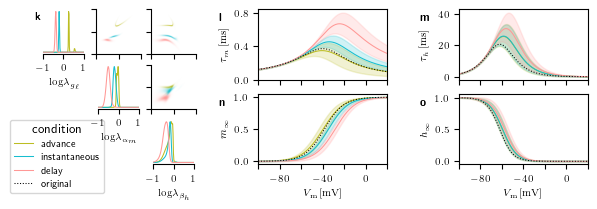

In [6]:
sbi_id = '002'

posterior_path = '../data/sbi/003/posterior.p'
yticks = {'tau_m': [0, 0.4, 0.8]}
get_im_kw = {'n_samples': 10_000_000}
add_gridspec_kw = {'wspace': 0.5, 'height_ratios': [3,2]}
add_gridspec_kw = {}
median = False
legend='left'

plot_kw = {'lw': .75}

chars = string.ascii_lowercase[10:]

colors = [plt.colormaps['tab20'](i) for i in [16, 18, 7]]

chars = string.ascii_lowercase[10:]

plot_final_posterior(sbi_id, posterior_path=posterior_path, limits=np.array([[-1,1]]*3), colors=colors, yticks=yticks, fontsize=7, label_fontsize=8, figsize=(6.2, 2), plot_std=True, n_samples=10_000, add_gridspec_kw=add_gridspec_kw, plot_kw=plot_kw, median=median, legend=legend, chars=chars)

# plt.savefig('posterior_mean.svg', dpi=300)
# plt.savefig('posterior_mean.pdf', dpi=300, facecolor='w')

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

array([[<Axes: xlabel='$\\lambda_{g_\\ell}$'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: xlabel='$\\lambda_{\\bar{g}_{\\rm Na}}$'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='$\\lambda_{\\bar{g}_{\\rm K}}$'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='$\\lambda_{\\alpha_{\\rm m}}$'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='$\\lambda_{\\beta_{\\rm m}}$'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='$\\lambda_{\\alpha_{\\rm h}}$'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='$\\lam

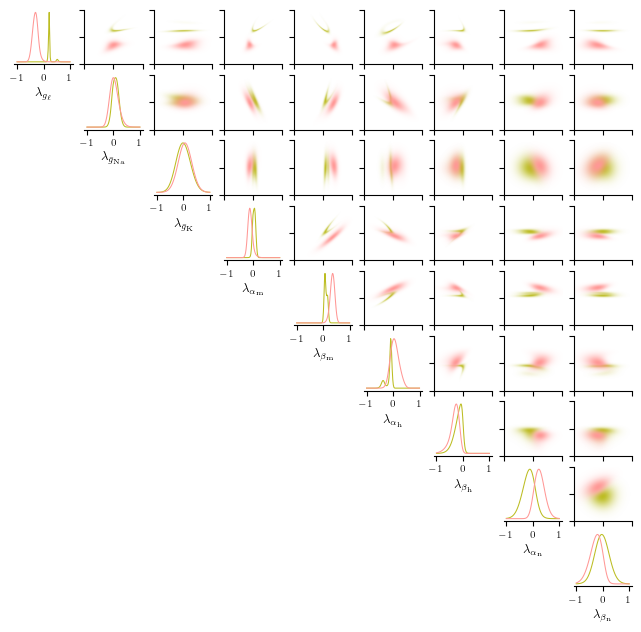

In [8]:
seed = None
experiment_id = '001'
posterior_path = '../data/sbi/001/posterior.p'
figsize = (6.3,6.3)
fontsize = 7
colors = [plt.colormaps['tab20'](i) for i in [16, 7]]
plot_conditional_posterior(experiment_id, posterior_path=posterior_path, colors=colors, seed=seed, n_samples=1_000_000, figsize=figsize, fontsize=fontsize)

# plt.savefig('Fig-A2_conditional_posterior_9d.svg', facecolor='w')
# plt.savefig('Fig-A2_conditional_posterior_9d.png', facecolor='w', dpi=300)

In [9]:
   
def plot_posterior_check_examples(posterior_check_ids, save_dir=None, posterior_check_paths=None, example_paths=None, figsize=(6.3, 3),
                                  fontsize=12, label_fontsize=16, label_case='lower', arrow_y=None, arrow_text_ha='left',
                                  arrow_text_x_offset=0, example_colors=None, posterior_check_colors=None, subfigs_kw={},
                                  examples_gridspec_kw={}, plot_phase_shift_kw={}):
    
    include_example_id = 1
    alpha_examples = 1
    
    if save_dir is None:
        # ToDo add standard path
        raise NotImplementedError
        
    if posterior_check_paths is None:
        posterior_check_paths = []
        for pc_id in posterior_check_ids:
            file_path = os.path.join(save_dir, pc_id, 'simulation_results.p')
            assert os.path.isfile(file_path)
            posterior_check_paths.append(file_path)
    else:
        assert len(posterior_check_paths) == len(posterior_check_ids)
        
    if example_paths is None:
        example_paths = []
        for pc_id in posterior_check_ids:
            file_path = os.path.join(save_dir, pc_id, 'posterior_check_example.p')
            assert os.path.isfile(file_path)
            example_paths.append(file_path)
    n_examples = len(example_paths)
    
    subfigs_kw = subfigs_kw.copy()
    subfigs_kw.setdefault('height_ratios', [3,1])
    subfigs_kw.setdefault('hspace', .15)
    
    
    
    cmap = plt.colormaps['tab10']
    if example_colors is None:
        example_colors = [cmap(i) for i in range(n_examples)]
    if posterior_check_colors is None:
        posterior_check_colors = [cmap(i) for i in range(len(posterior_check_ids))]
    
    subsubfigs_kw = {}
    subsubfigs_kw = subsubfigs_kw.copy()
    subsubfigs_kw.setdefault('wspace', -0.05)
    subsubfigs_kw.setdefault('hspace', .0)
    
    examples_gridspec_kw = examples_gridspec_kw.copy()
    examples_gridspec_kw.setdefault('hspace', .2)
    examples_gridspec_kw.setdefault('left', .25)
    examples_gridspec_kw.setdefault('right', .95)
    examples_gridspec_kw.setdefault('top', .95)
    
    posteriot_check_gridspec_kw = {}
    posteriot_check_gridspec_kw = posteriot_check_gridspec_kw.copy()
    posteriot_check_gridspec_kw.setdefault('left', examples_gridspec_kw['left']/n_examples)
    posteriot_check_gridspec_kw.setdefault('right', 1 - (1 - examples_gridspec_kw['right'])/n_examples)
    posteriot_check_gridspec_kw.setdefault('bottom', 0.35)
    posteriot_check_gridspec_kw.setdefault('top', 1)
    
    default_plot_kw = {}
    default_plot_kw = default_plot_kw.copy()
    default_plot_kw.setdefault('alpha', alpha_examples)
    default_plot_kw.setdefault('lw', .75)
    
    i0_plot_kw = {}
    i0_plot_kw = i0_plot_kw.copy()
    phase_shift_plot_kw_1 = {}
    phase_shift_plot_kw_1 = phase_shift_plot_kw_1.copy()
    phase_shift_plot_kw_2 = {}
    phase_shift_plot_kw_2 = phase_shift_plot_kw_1.copy()

    plot_kw_hat = {}
    plot_kw_hat = plot_kw_hat.copy()
    plot_kw_line_between = {}
    plot_kw_line_between = plot_kw_line_between.copy()
    
    posterior_check_plot_kw = {}
    posterior_check_plot_kw = posterior_check_plot_kw.copy()

    if phase_shift_plot_kw_2.get('type_2', 'bar') == 'bar':
        phase_shift_plot_kw_2.setdefault('color', 'w')
        phase_shift_plot_kw_2.setdefault('edgecolor', 'k')
        phase_shift_plot_kw_2.setdefault('lw', 0.2)
        
    plot_kw_line_between.setdefault('alpha', 1)
        
    for k, v in default_plot_kw.items():
        i0_plot_kw.setdefault(k, v)
        phase_shift_plot_kw_1.setdefault(k, v)
        phase_shift_plot_kw_2.setdefault(k, v)
        plot_kw_hat.setdefault(k, v)
        plot_kw_line_between.setdefault(k, v)
        posterior_check_plot_kw.setdefault(k, v)
        
    plot_kw_hat_2 = plot_kw_hat.copy()
    plot_kw_hat['c'] = 'k'

    plot_phase_shift_kw = plot_phase_shift_kw.copy()
    plot_phase_shift_kw.setdefault('arrow_y', 30)
    plot_phase_shift_kw.setdefault('arrow_y_offset', None)
    plot_phase_shift_kw.setdefault('arrow_text_y_offset', 5)
    plot_phase_shift_kw.setdefault('type_1', None)
    plot_phase_shift_kw.setdefault('type_2', 'bar')
    plot_phase_shift_kw.setdefault('plot_kw_1', phase_shift_plot_kw_1)
    plot_phase_shift_kw.setdefault('plot_kw_2', phase_shift_plot_kw_2)
    plot_phase_shift_kw.setdefault('plot_kw_hat', plot_kw_hat)
    plot_phase_shift_kw.setdefault('plot_kw_hat_2', plot_kw_hat_2)
    plot_phase_shift_kw.setdefault('plot_kw_line_between', plot_kw_line_between)
    plot_phase_shift_kw.setdefault('arrow_ax', 'bottom')
    plot_phase_shift_kw.setdefault('arrow_from', 'top')
    plot_phase_shift_kw.setdefault('arrow_min_dx', 0.05)
    
    arrow_text_kw = {}
    arrow_text_kw = arrow_text_kw.copy()
    arrow_text_kw.setdefault('size', fontsize)
    arrow_text_kw.setdefault('bbox', {'alpha': 0})
    if type(arrow_text_ha) is str:
        arrow_text_ha = [arrow_text_ha] * n_examples
    assert len(arrow_text_ha) == n_examples
    if type(arrow_text_x_offset) is not list:
        arrow_text_x_offset = [arrow_text_x_offset] * n_examples
    assert len(arrow_text_x_offset) == n_examples
        
    posterior_check_hist_kw = {}
    posterior_check_hist_kw = posterior_check_hist_kw.copy()
    posterior_check_hist_kw.setdefault('bins', 100)
    posterior_check_hist_kw.setdefault('alpha', alpha_examples)
    
    fig = plt.figure(figsize=figsize)
    
    subfigs = fig.subfigures(2, 1, **subfigs_kw)
    subsubfigs = subfigs[0].subfigures(1, n_examples, **subsubfigs_kw)
    
    axes = []
    lines = []
    for i_ex, ex_path in enumerate(example_paths):
        sf = subsubfigs[i_ex]
        axs = sf.subplots(3, 1, sharex=True, gridspec_kw=examples_gridspec_kw)
        
        subplot = sf.add_gridspec(3, 1, **examples_gridspec_kw)[:2]
        
        with open(ex_path, 'rb') as tmp:
            variables = pickle.load(tmp)
        from brian2 import second, ms

        v = variables['v']['mean']
        v0 = variables['v'][0]
        I = variables['I']['mean'] * 1e9
        I0 = variables['I'][0] * 1e9
        
        t = np.arange(0, len(v)*1e-4, 1e-4)
        
        hist_kw = {'bins': 100}
        
        t_s, s = variables['spikes']['t'], variables['spikes']['all']
        t_FR, FR = psth(t_s, N=10_000, hist_kw=hist_kw)
        
        arrow_text_kw_ = arrow_text_kw.copy()
        arrow_text_kw_['ha'] = arrow_text_ha[i_ex]
        arrow_text_x = 'right' if arrow_text_ha[i_ex] == 'left' else 'left'
        
        i0_plot_kw_ = i0_plot_kw.copy()
        i0_plot_kw_['c'] = example_colors[i_ex]
        
        plot_phase_shift_kw['plot_kw_hat_2']['c'] = example_colors[i_ex]

        
        plot_variable(t, I0, ax=axs[0], fontsize=fontsize, plot_kw=i0_plot_kw_, legend=None, xlabel=None)
        plot_phase_shift((t, I), (t_FR, FR), ax1=axs[0], ax2=axs[1], fig=sf,  # subsubfigs[i_ex],
                         subplot=subplot, fontsize=fontsize, arrow_text_kw=arrow_text_kw_,
                         arrow_text_x=arrow_text_x, arrow_text_x_offset=arrow_text_x_offset[i_ex],
                         **plot_phase_shift_kw)
        
        plot_variable(t, v0, ax=axs[2], fontsize=fontsize, plot_kw=i0_plot_kw_, legend=None)
        if include_example_id is not None:
            assert type(include_example_id) is int
            with open(example_paths[include_example_id], 'rb') as tmp:
                tmp_ = pickle.load(tmp)
                v_ = tmp_['v'][0]
            kw_ = i0_plot_kw_.copy()
            kw_['c'] = 'k'
            kw_['alpha'] = .75
            kw_['ls'] = ':'
            
            plot_variable(t, v_, ax=axs[2], fontsize=fontsize, plot_kw=kw_, legend=None)
        
        if i_ex == 0:
            axs[0].set_ylabel(get_label('I'), size=fontsize)
            axs[1].set_ylabel(get_label('psth'), size=fontsize)
            axs[2].set_ylabel(get_label('v'), size=fontsize)
            sf.align_ylabels(axs)
        
        
        axs[2].spines['top'].set_visible(False)
        axs[2].spines['right'].set_visible(False)
        
    
        ylim = axs[1].get_ylim()
        axs[1].set_ylim([0, ylim[1]])

        for ax in axs:
            axes.append(ax)
    
    ax = subfigs[1].subplots(1, gridspec_kw=posteriot_check_gridspec_kw)
    for i_pc, pc_id in enumerate(posterior_check_ids):
        experiment_params = config.experiment['posterior_check'][pc_id]
        with open(posterior_check_paths[i_pc], 'rb') as tmp:
            variables = pickle.load(tmp)
        x_o = - experiment_params['x_o']
        
        x = variables['x']
        thetas = variables['theta']
        
        posterior_check_plot_kw_ = posterior_check_plot_kw.copy()
        posterior_check_hist_kw_ = posterior_check_hist_kw.copy()
        if posterior_check_colors is not None:
            posterior_check_plot_kw_['c'] = posterior_check_colors[i_pc]
            posterior_check_hist_kw_['color'] = posterior_check_colors[i_pc]
        
        posterior_check_hist_kw={'bins': 100, 'color': cmap(i_pc), 'alpha': 0.75}
        plot_posterior_check(x_o, x, ax=ax, fontsize=fontsize, hist_kw=posterior_check_hist_kw_, plot_kw=posterior_check_plot_kw_)
        
    axes.append(ax)

    if label_fontsize is not None:
        if label_case == 'lower':
            chars = string.ascii_lowercase
        else:
            assert label_case == 'upper'
            chars = string.ascii_uppercase
        props = dict(boxstyle='round', facecolor='w', ec='w', pad=.1, alpha=0)
        n_row = n_col = 3
        i_labels = [i_row + i_col*3 for i_row in range(3) for i_col in range(3)] + [n_row * n_col]
        for i_ax, i_label in enumerate(i_labels):
            ax = axes[i_ax]
            label = r'${\textbf ' + chars[i_label] + '}$'
            x0 = -.075
            if i_ax == len(axes) - 1:
                x0 /= 4
                print(label)
            ax.text(x0, .94, label, fontsize=label_fontsize, transform=ax.transAxes, bbox=props, va='top', ha='left')#, weight='bold')
    plt.subplots_adjust(left=0, right=1, wspace=.5)
    return axes


In [ ]:
from experiment import get_model_from_experiment, store_variable

posterior_check_ids = ['001', '002', '003']
# second example for id 001, because first example spikes irregular
idxs = [1, 0, 0]

save_dir = '../data/posterior_check'

seed = 20221107

models = {}

for pc_id, pc_idx in zip(posterior_check_ids[:1], idxs[:1]):
    experiment_params = config.experiment['posterior_check'][pc_id]
    sbi_id = experiment_params['sbi_experiment_id']
    sbi_params = config.experiment['sbi'][sbi_id]


    file_path = os.path.join(save_dir, pc_id, 'simulation_results.p')
    with open(file_path, 'rb') as tmp:
        variables = pickle.load(tmp)
    x = variables['x']
    thetas = variables['theta']
    idx = np.argsort(abs(x - experiment_params['x_o']))[pc_idx]

    m = get_model_from_experiment('sbi', experiment_id=sbi_id, results=thetas[idx], seed=seed)

    save_variables = {'I': {'mean': True, 'i': 0}, 'v': {'mean': True, 'i': 0}}
    save_dict = {}
    store_variable(save_dict, m, 'spikes', 'all')
    for v, i in save_variables.items():
        store_variable(save_dict, m, v, i)

    save_path = os.path.join(save_dir, pc_id, 'posterior_check_example_{}.p'.format(pc_idx))
    with open(save_path, 'wb') as tmp:
        pickle.dump(save_dict, tmp)


${\textbf j}$


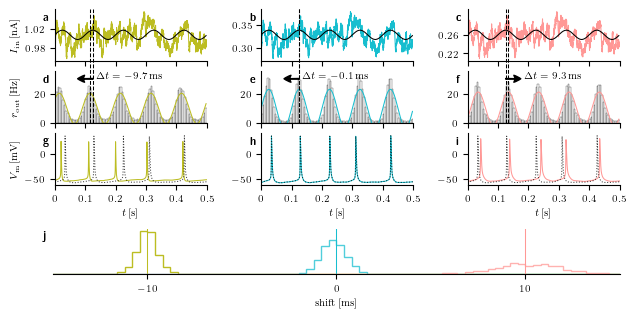

In [10]:
save_dir = '../data/posterior_check'

posterior_check_ids = ['001', '002', '003']
# second example for id 001, because first example spikes irregular
idxs = [1, 0, 0]

example_paths = [os.path.join(save_dir, pc_id, 'posterior_check_example_{}.p'.format(idx)) for pc_id, idx in zip(posterior_check_ids, idxs)]

fontsize = 7
label_fontsize = 8

arrow_y = 24

arrow_text_ha = ['left']*3
arrow_text_x_offset = [0.036, 0.04, 0.01]
arrow_text_x_offset = [0.01, 0.01, 0.05]
example_colors = [plt.colormaps['tab20'](i) for i in [16, 18, 7]]

plot_phase_shift_kw = {'arrow_text': r'$\Delta t=<sign*shift>\,{\rm <unit>}$', 'arrow_text_y_offset': 0}
axs = plot_posterior_check_examples(
    posterior_check_ids, save_dir, example_paths=example_paths, fontsize=fontsize, label_fontsize=label_fontsize, arrow_text_ha=arrow_text_ha,
    arrow_y=arrow_y, arrow_text_x_offset=arrow_text_x_offset, example_colors=example_colors, posterior_check_colors=example_colors,
    plot_phase_shift_kw=plot_phase_shift_kw)
    
axs[-1].set_xlim([-0.015, 0.015])
axs[-1].set_xticks([-0.01, 0, 0.01], [r'$-10$', r'$0$', r'$10$'])
axs[-1].set_xlabel(r'${\rm shift\,[ms]}$', size=fontsize)

for i in range(3):
    yticks = [[0.98, 1.02], [0.3, 0.35], [0.22, 0.26]]
    ax = axs[i*3]
    ax.set_yticks(yticks[i])
    ax = axs[i*3 + 1]
    ax.set_ylim([0, 35])
    ax = axs[i*3 + 2]
    ax.set_yticks([-0.05, 0], [r'$-50$', r'$0$'])
    ax.set_xticks(np.arange(0, 0.6, 0.1), [r'$0$'] + [r'$0.{}$'.format(i) for i in range(1, 6)])
    

# plt.savefig('Fig-2_posterior_check.svg', pad_inches=0.1, dpi=300)
# plt.savefig('Fig-2_posterior_check.pdf', pad_inches=0.1, dpi=300, facecolor='w')